In [1]:
import pandas as pd
import numpy as np
import os

# Perimeter

In [328]:
data = pd.read_parquet("../data/edited_data/modeling/data")

In [329]:
data = data.drop(
    columns=[
        "numVotes",
        "title", 
        "titleType", 
        "Movie", 
        "titleBasicsFlag",
        "primaryTitle",
        "ReleaseDate",
        "nObs",
        "WorldwideGross"],
    axis=1
)

In [330]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277451 entries, tt0000038 to tt9916720
Data columns (total 15 columns):
averageRating_name      199591 non-null float64
numVotes_name           199591 non-null float64
averageRating_genres    277451 non-null float64
numVotes_genres         277451 non-null float64
ProductionBudget        3978 non-null float64
DomesticGross           3978 non-null float64
nLetters                277451 non-null float64
nCapitalLetters         277451 non-null float64
nWords                  277451 non-null float64
actor                   78590 non-null float64
director                53534 non-null float64
other                   55131 non-null float64
producer                26142 non-null float64
averageRating           277451 non-null float64
genres                  271751 non-null object
dtypes: float64(14), object(1)
memory usage: 33.9+ MB


In [331]:
data.head()

,averageRating_name,numVotes_name,averageRating_genres,numVotes_genres,ProductionBudget,DomesticGross,nLetters,nCapitalLetters,nWords,actor,director,other,producer,averageRating,genres
tconst,,,,,,,,,,,,,,,
tt0000038,NaN,NaN,7.170422,54.924635,NaN,NaN,13.0,3.0,3.0,NaN,NaN,NaN,NaN,4.2,"Documentary,Short,Sport"
tt0000417,NaN,NaN,7.170422,54.924635,NaN,NaN,18.0,3.0,5.0,NaN,NaN,NaN,NaN,8.2,"Action,Adventure,Comedy"
tt0001440,NaN,NaN,6.226725,5076.682366,NaN,NaN,13.0,2.0,2.0,NaN,NaN,NaN,NaN,4.8,"Drama,History"
tt0001563,NaN,NaN,7.170422,54.924635,NaN,NaN,24.0,4.0,5.0,NaN,NaN,NaN,NaN,5.8,"Crime,Drama,Short"
tt0001889,NaN,NaN,6.226725,5076.682366,NaN,NaN,12.0,1.0,1.0,NaN,NaN,NaN,NaN,4.0,None


### Exploratory analysis

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 277451 entries, tt0000038 to tt9916720
Data columns (total 15 columns):
averageRating_name      199591 non-null float64
numVotes_name           199591 non-null float64
averageRating_genres    277451 non-null float64
numVotes_genres         277451 non-null float64
ProductionBudget        3978 non-null float64
DomesticGross           3978 non-null float64
nLetters                277451 non-null float64
nCapitalLetters         277451 non-null float64
nWords                  277451 non-null float64
actor                   78590 non-null float64
director                53534 non-null float64
other                   55131 non-null float64
producer                26142 non-null float64
averageRating           277451 non-null float64
genres                  271751 non-null object
dtypes: float64(14), object(1)
memory usage: 33.9+ MB


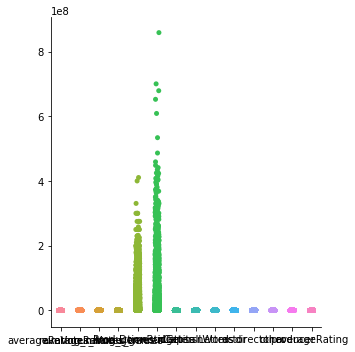

In [96]:
sns.catplot(data=data)

In [334]:
data["genres_first"] = data.genres.str.split(",", expand=True)[0]

In [81]:
data.groupby("genres_first").size().apply(lambda x: x/data.shape[0]).sort_values(ascending=False).nlargest(5)

genres_first
Drama          0.248934
Comedy         0.218039
Documentary    0.117394
Action         0.097898
Horror         0.041290
dtype: float64

In [144]:
perimeter = data[data.genres_first.isin(["Drama", "Comedy", "Documentary", "Action"])]

#### Target

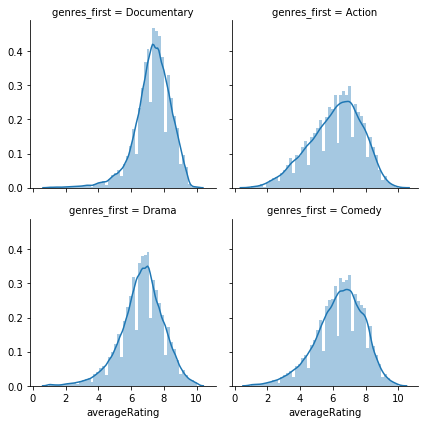

In [88]:
g = sns.FacetGrid(perimeter, col="genres_first", col_wrap=2)
g.map(sns.distplot, "averageRating")

#### correlations

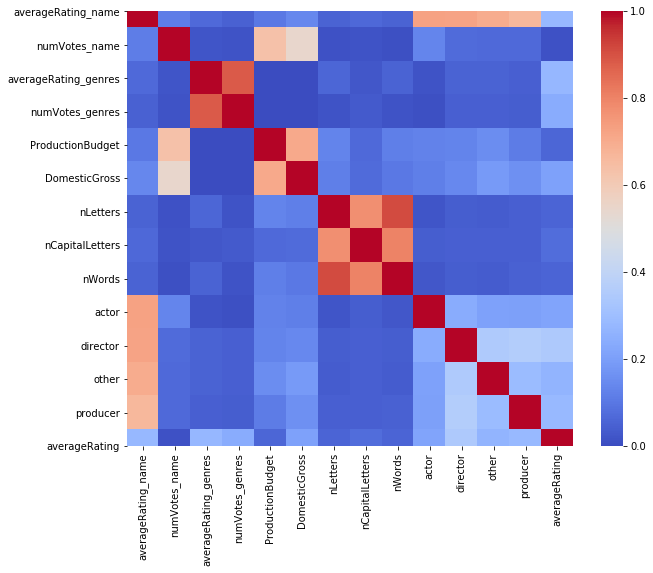

In [93]:
corr = np.abs(perimeter.corr())

fig = plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm")

### Features engineering

#### discretize

In [419]:
perimeter = data[data.genres_first.isin(["Drama", "Comedy", "Documentary", "Action"])]

for category in ["actor", "director", "other", "producer"]:
    cut = pd.cut(perimeter[category], 3, labels=False)
    perimeter[category] = np.where(perimeter[category].isnull(), -1, cut)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [420]:
perimeter.director.value_counts()

-1.0    149950
 1.0     22483
 2.0     15533
 0.0      1329
Name: director, dtype: int64

In [421]:
def get_rate_classes(rate):
    if rate < 5:
        return 0
    if rate < 8:
        return 1
    else:
        return 2

#perimeter["target"] = (perimeter.averageRating > 8).astype(int)

perimeter["target"] = perimeter.averageRating.apply(get_rate_classes)
#(data.averageRating >= mean_avg_ratings).astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


dropped columns after correlation analysis

In [422]:
cols_drop = [
    "numVotes_name", 
    "averageRating",
    "nLetters", 
    "nCapitalLetters", 
    "averageRating_genres", 
    "numVotes_genres",
    "genres",
    "genres_first",
    "ProductionBudget",
    "DomesticGross",
    "averageRating_name"
]

In [423]:
perimeter.drop(cols_drop, axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Index: 189295 entries, tt0000038 to tt9916720
Data columns (total 6 columns):
nWords      189295 non-null float64
actor       189295 non-null float64
director    189295 non-null float64
other       189295 non-null float64
producer    189295 non-null float64
target      189295 non-null int64
dtypes: float64(5), int64(1)
memory usage: 10.1+ MB


### modeling

In [432]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [425]:
perimeter = perimeter.drop(columns=cols_drop, axis=1).dropna()

In [426]:
X = perimeter.drop(columns=["target"], axis=1)
y = perimeter.target

In [427]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=12345)

In [452]:
y_train.value_counts()

1    94068
2    22240
0    16198
Name: target, dtype: int64

In [428]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

In [438]:
clf = RandomForestClassifier()
param_grid = {
    'max_depth': [10, None],
    'n_estimators': [100, 500, 1000]
}

grid = GridSearchCV(estimator=clf, param_grid=param_grid, verbose=2)

grid.fit(X_train_scaled, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   2.4s
[CV] max_depth=10, n_estimators=100 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV] ................... max_depth=10, n_estimators=100, total=   2.2s
[CV] max_depth=10, n_estimators=100 ..................................
[CV] ................... max_depth=10, n_estimators=100, total=   2.2s
[CV] max_depth=10, n_estimators=500 ..................................
[CV] ................... max_depth=10, n_estimators=500, total=  12.5s
[CV] max_depth=10, n_estimators=500 ..................................
[CV] ................... max_depth=10, n_estimators=500, total=  12.4s
[CV] max_depth=10, n_estimators=500 ..................................
[CV] ................... max_depth=10, n_estimators=500, total=  12.2s
[CV] max_depth=10, n_estimators=1000 .................................
[CV] .................. max_depth=10, n_estimators=1000, total=  24.8s
[CV] max_depth=10, n_estimators=1000 .................................
[CV] .................. max_depth=10, n_estimators=1000, total=  24.9s
[CV] max_depth=10, n_estimators=1000 .................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  4.3min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [444]:
y_pred = grid.predict(X_test_scaled)

In [453]:
print(classification_report(y_train, grid.predict(X_train_scaled)))

              precision    recall  f1-score   support

           0       0.67      0.02      0.04     16198
           1       0.71      1.00      0.83     94068
           2       0.82      0.00      0.01     22240

    accuracy                           0.71    132506
   macro avg       0.73      0.34      0.29    132506
weighted avg       0.73      0.71      0.60    132506



In [296]:
contributions = dict(zip(X.columns.tolist(), np.abs((np.std(X_train_scaled, 0) * clf.coef_)[0])))

In [297]:
pd.DataFrame.from_dict(contributions, orient="index").sort_values(by=0, ascending=False)

,0
nWords,0.214649
actor,0.149491
director,0.149491
other,0.149491
producer,0.149491
